# Lab 3: 反復位相推定


量子位相推定（Quantum phase estimation, QPE）アルゴリズムは、最も重要で有名な量子アルゴリズムの1つです。Shorの因数分解アルゴリズムの重要なサブルーチンであり、量子シミュレーションのアルゴリズムでもあります。このアルゴリズムのテキストブックのバージョンは、精度に応じて数がスケールする補助量子ビットを使用するため、今日のノイズのあるデバイスでは量子ビットの数や接続性が限られていることから、実行が困難な回路となっています。

反復位相推定（Iterative phase estimation, IPE）は、1つの補助量子ビットしか必要としないQPEの変種です。IPEでは、補助量子ビットを繰り返し測定し、測定結果をその後の量子演算の補助として利用します。Dynamic circuit(動的回路)が導入されるまで、このような古典的なフィードフォワードは、IBMの量子ハードウェアでは実行不可能でした。

ここでは、最近実装されたDynamic circuitの機能を使って、IPEを実装します。

## 背景

他の位相推定アルゴリズムと同じように、IPEは以下の問題を解くために設計されています：

**問題文:** ユニタリー行列 $U$ と 未知の固有値 $e^{i 2\pi \varphi}$ を持つ $U$ の固有状態 $|\Psi\rangle$ が与えられたとき、 $\varphi$ の値を推定せよ。

この問題文では、いくつかの重要な詳細を明らかにする必要があります。すなわち、 $U$ と $|\Psi\rangle$ がどのように指定されるかです。 $U$ は $U$ を実装した量子回路として与えられ、実際に、正の整数 $t$ に対して *制御*  $U^{2^t}$ という演算を効率よく実装できる能力があると仮定します。これは、オリジナルのQPEアルゴリズムで用いられたものと同じ仮定です。固有状態も量子回路として与えられます：つまり、 $|\Psi\rangle$ を効率的に準備できると仮定します。


まず、簡単のために、 $\varphi$ が正確なバイナリー展開できると仮定しましょう。つまり、次のように書くことができると仮定します。

$$
\varphi = \varphi_1/2 + \varphi_2/4 + \cdots + \varphi_m/2^m = 0.\varphi_1 \varphi_2 \cdots \varphi_m
$$

ここで、最後の等式では、二進数の「小数」表記を使用しています。簡単のために、 $U$ が1つの量子ビットに作用するユニタリー演算子であるとします（ここで述べていることはすべて、 $U$ が複数の量子ビットに作用する場合にも適用されます）。IPEは補助量子ビットを必要とするので、 $q_0$ と $q_1$ という2つの量子ビットのシステムが必要であり、 $q_0$ は補助量子ビット、 $q_1$ は $U$ が作用する物理系を表します。

ここで、 $q_0$ を $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ の状態に、 $q_1$ を $|\Psi \rangle$ の状態に初期化するとします。  $q_0$ をコントロール、 $q_1$ をターゲットとして、 *制御* $U^{2^t}$ ゲートを適用するとどうなるでしょうか?  $|\Psi \rangle$ は固有値  $e^{i 2\pi \varphi}$ を持つ $U$ の固有状態であるため、次のようになります。
$$
\begin{align}
|+\rangle |\Psi \rangle &= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) |\Psi \rangle \\
&= \frac{|0\rangle |\Psi \rangle + |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&\xrightarrow{\text{controlled-}U^{2^t}} \frac{|0\rangle |\Psi \rangle + e^{i 2 \pi 2^{t} \varphi} |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&= \left(\frac{|0\rangle  + e^{i 2 \pi 2^{t} \varphi} |1\rangle}{\sqrt{2}}\right) |\Psi \rangle.
\end{align}
$$

つまり、システム量子ビットの状態は変化しませんが、位相 $e^{i 2 \pi 2^{t} \varphi}$ が補助量子ビットの状態に「キックバック」されました。

ここで、次のことに注意してください。

$$
e^{i 2 \pi 2^{t} \varphi} = e^{i 2 \pi 2^{t} (0.\varphi_1 \varphi_2 \cdots \varphi_m)}
= e^{i 2 \pi (\varphi_1 \cdots \varphi_t . \varphi_{t + 1} \cdots \varphi_m)}
= e^{i 2 \pi (0. \varphi_{t + 1} \cdots \varphi_m)},
$$

ここで、最後の等式では、任意の整数 $n$ に対して  $e^{i 2\pi n} = 1$  であるため、位相の「小数」表現の整数部分が消えています。 例えば：

- $t=0$ の場合、位相は $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$ になります。
- $t=1$ の場合、位相は $e^{i 2 \pi 2^{1} \varphi}= e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m} = e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$ になります。
- $t=2$ の場合、位相は $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$ になります。
- $t=m-1$ の場合、位相は $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 0.\varphi_m}$ になります。


$t = m - 1$ の最後のケースでは、位相は $e^{i 2 \pi 0.\varphi_m}$ で、 $\varphi_m = 0$ の場合は $1$ 、 $\varphi_m = 1$ の場合は $-1$ に等しくなります。 最初のケースでは、補助量子ビット $q_0$ は  $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ の状態になり、2 番目のケースでは $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$ の状態になります。 したがって、パウリの $X$ 基底で量子ビットを測定すると、これらのケースを 100% の成功率で区別できます。 これは、量子ビットを測定する前に量子ビットに対してアダマール ゲートを実行することによって行われます。 最初のケースでは 0 を測定し、2 番目のケースでは 1 を測定します。 言い換えれば、測定されたビットは $\varphi_m$ と等しくなります。

### アルゴリズム


IPE アルゴリズムの最初のステップでは、上記で説明したように 2 量子ビットレジスターを初期化 ( $q_0 \rightarrow |+\rangle$ と $q_1 \rightarrow |\Psi \rangle$ )し、*制御* $U^{2^{m-1}}$ を実行することで、位相$\varphi$の最下位ビット$\varphi_m$を直接測定し、パウリの $X$ 基底で $q_0$ を測定します。


2 番目のステップでは、同じ方法でシステムを初期化し、*制御* $U^{2^{m-2}}$ 演算を適用します。 これらの操作後の $q_0$ の相対位相は $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$ になります。 位相ビット $\varphi_{m-1}$ を抽出するには、まず $Z$ 軸の周りを角度 $-2 \pi \varphi_m/4=-\pi \varphi_m/2$ だけ回転させて位相補正を実行します。その結果、$q_0$ の状態は $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$ になります。 パウリの $X$ 基底で $q_0$ の測定を実行し、位相ビット $\varphi_{m-1}$ を取得します。

したがって、 $\varphi_{m-k+1}$ を取得する IPE の $k$ 番目のステップは、レジスターの初期化 ($q_0$ を $|+\rangle$ に、 $q_1$ を $|\Psi\rangle$ に)、*制御* $U^{2^{m-k}}$ の適用、および$Z$ 軸周りの角度  $\omega_k = -2 \pi 0.0\varphi_{m-k+2} ... \varphi_m$ の回転とパウリの $X$ 基底での $q_0$ の測定(つまり、 $q_0$ をアダマール変換後、計算基底で $q_0$ を測定)、から構成されます。 $q_1$ はアルゴリズム全体を通じて状態 $|\Psi\rangle$ のままであることに注意してください。

## 実装


このLabでは、単一量子ビットの $S$ ゲートのIPEを行います。 $S$ ゲートは、次の行列で与えられます。

$$ S =
\begin{bmatrix}
1 & 0\\\\
0 & e^{i\pi / 2}\\\\
\end{bmatrix}$$


固有値 $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$ を持つ、固有ベクトル $|\Psi\rangle = |1\rangle$ を使います。よって、 $\varphi = 1/4 = 0.01 = 0.\varphi_1 \varphi_2$ となります。 $\varphi$ は2ビットで完全に表現できるため、結果を格納するための2ビットの古典ビットを持つ量子回路を使います。


制御 $S$ ゲートは、制御位相ゲート(Qiskitでは `CPhaseGate` )を使って実装でき、 `QuantumCircuit` の `cp` メソッドを呼び出すことでも適用できます。制御位相ゲートは角度 $\theta$ でパラメーター化され、次の行列を持ちます。

$$
        \text{CPhase}(\theta) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\theta}
            \end{pmatrix}
$$


### ステップ 1

アルゴリズムの最初のステップで、 $\varphi$の最下位ビットを測定します。

そのためには以下のステップを実行します。：
1. 量子ビットを初期化します:
   - 補助量子ビットにアダマールゲートを適用。
   - Xゲートをシステムの量子ビットに適用し、 $|1\rangle$ の状態にする。
2. 適当な角度の `CPhaseGate` を適用することで、*制御* $S^{2}$ ゲートを適用します。
3. $X$ 基底で補助量子ビットを測定します:
   - 補助量子ビットにアダマールゲートを適用。
   - 計算基底で上記を測定。

その結果回路は、以下のようになるはずです：

![step1-circuit](resources/2023-spring-step1circuit.png)

## Exercise 1 問題

````{admonition} ステップ1の実装
ステップ1の実行をQiskitで実装してみましょう。

```python
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")
```
````

## Exercise 1 解答例

/Users/kosukehirano/.local/share/virtualenvs/quantum-BrbwwRIy/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


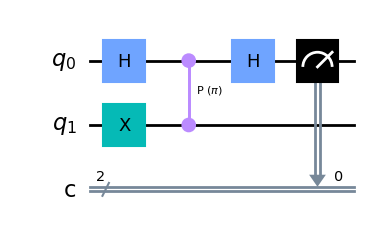

In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qrは2量子ビットレジスタ
    # crは2古典ビットレジスタ

    qc = QuantumCircuit(qr, cr)

    ##1. 量子ビットを初期化
    q0, q1 = qr
    # 補助量子ビット（q0）にアダマールゲートを適用
    qc.h(q0)
    # Xゲートをシステムの量子ビットに適用し、|1>の状態にする。
    qc.x(q1)

    ##2. 制御位相ゲートを適用する。
    # 制御Sゲートは位相πのCPhaseと等しい
    s_angle = np.pi / 2
    # 制御Sゲートを2^k回適用する。
    # 今回は2量子ビットであり、ステップ1なので、k=2-1=1
    k = 1
    cphase_angle = s_angle * 2**k
    # 制御位相ゲートを適用
    qc.cp(cphase_angle, q0, q1)

    ##3. X基底で補助量子ビットを測定する。
    # 補助量子ビット（q0）にアダマールゲートを適用
    qc.h(q0)
    # 測定し、結果をc0に格納
    c0, _ = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")

### ステップ 2

ステップ 1では、最下位ビット $\varphi_2$ を測定しました。ステップ 2（最終ステップ）では、次のビット $\varphi_1$ を抽出します。このとき、 $\varphi_2$ からの位相寄与を打ち消すために位相補正を適用することになります。この位相補正は、 $\varphi_2$ を保持する古典レジスターの値に依存します。この古典的なフィードバックを行うには、Dynamic circuitが必要です！位相補正は、 `PhaseGate` を使うか、QuantumCircuitの `p` メソッドを直接呼び出すことで適用することができます。

具体的には、ステップ1に続き以下のステップを実行することで、 $\varphi$ の次のビットを得ることができます：

1. 補助量子ビットをリセットして再初期化する。
2. 制御ユニタリーゲートを適用する。
3. 補助量子ビットを $X$ 基底で測定する。

その結果回路は、以下のようになるはずです：

![step1-circuit](resources/2023-spring-step2circuit.png)

## Exercise 2 問題

````{admonition} ステップ2の実装
ステップ2の実行をQiskitで実装してみましょう。
このExerciseでは、Exercise1で作成したステップ1の回路から始めます。

```python
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)

    ####### your code goes here #######

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")
```
````

## Exercise 2 解答例

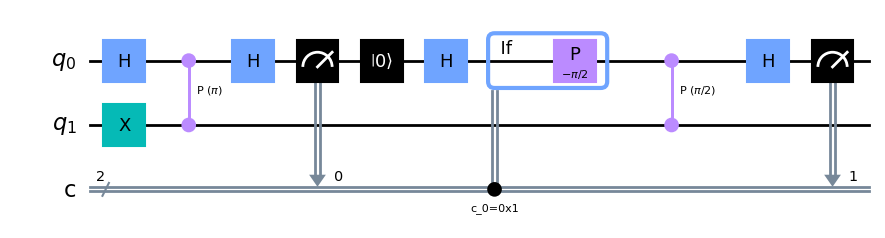

In [3]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qrは2量子ビットレジスタ
    # crは2古典ビットレジスタ

    # Exercise1で作成したステップ1の回路から始める。
    qc = step_1_circuit(qr, cr)

    ####### your code goes here #######

    ##1. 補助量子ビットをリセットして再初期化する。
    q0, q1 = qr
    # 補助量子ビットのリセット（|0>）
    qc.reset(q0)
    # アダマールゲートを適用し初期化
    qc.h(q0)

    ##2. φ_2の位相寄与を打ち消すために位相補正を適用
    c0, c1 = cr
    # 位相寄与は|1>のみに出るので、|0>のみについて位相補正を適用
    with qc.if_test((c0, 1)) as else_:
        qc.p(-np.pi/2, q0)

    
    ##3. 制御位相ゲートを適用する。
    # 制御Sゲートは位相πのCPhaseと等しい
    s_angle = np.pi / 2
    # 制御Sゲートを2^k回適用する。
    # 今回は2量子ビットであり、ステップ2なので、k=2-2=0
    k = 0
    cphase_angle = s_angle * 2**k
    # 制御位相ゲートを適用
    qc.cp(cphase_angle, q0, q1)

    ##4. X基底で補助量子ビットを測定する。
    # 補助量子ビット（q0）にアダマールゲートを適用
    qc.h(q0)
    # 測定し、結果をc1に格納
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")

## シミュレーターで実行

回路が完成したので、まずローカルシミュレーターで動かしてみましょう。

In [5]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'01': 1000}

回路が正しければ、100%の確率でビット列 `01` が得られるはずです。この値は、2進数で $\varphi = 0.01 = 1/4$ と書かれた位相に対応します。実際、これが正しい位相です！

## Exersise 3 問題

````{admonition} Tゲートの位相推定回路
以下で与えられる行列を持つ、Tゲートの位相を推定するIPE回路を構築してください。

$$ T =
\begin{bmatrix}
1 & 0\\\\
0 & e^{i\pi / 4}\\\\
\end{bmatrix}$$

この場合、位相を表すのに必要なビットは何ビットですか？

```python
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = t_gate_ipe_circuit(qr, cr)
qc.draw("mpl")
```
````

## Exersise 3 解答例
```{admonition} 
:class: tip
$T$ は固有値 $e^{i\pi / 4}= e^{i2\pi \times \frac{1}{8}}$ を持ちます。

よって $\varphi = \frac{1}{8} = 0.001_{(2)}$ であり、 $\varphi $ は3ビットで完全に表現されます。
```

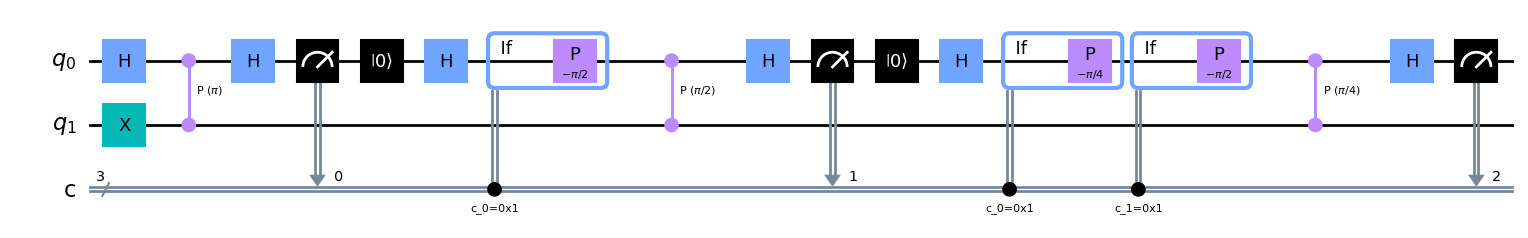

In [6]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qrは2量子ビットレジスタ
    # crは3古典ビットレジスタ

    qc = QuantumCircuit(qr, cr)

    # 初期化する
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # 最下位の位相ビットを取得するために必要なだけ制御ユニタリ演算子を適用する
    t_angle = np.pi / 4
    k = 2
    cphase_angle = t_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # X基底で補助量子ビットを測定する
    qc.h(q0)
    c0, c1, c2 = cr
    qc.measure(q0, c0)

    # 補助量子ビットをリセットし、アダマールゲートで再初期化する
    qc.reset(q0)
    qc.h(q0)

    # 最初の古典ビットを条件として位相補正を適用する
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # 次の位相ビットを取得するために必要なだけ制御ユニタリ演算子を適用する
    k = 1
    cphase_angle = t_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    #  X基底で補助量子ビットを測定し、2番目の古典ビットに格納する
    qc.h(q0)
    qc.measure(q0, c1)

    # 補助量子ビットをリセットし、アダマールゲートで再初期化する
    qc.reset(q0)
    qc.h(q0)

    # 一番目と二番目の古典ビットを条件として位相補正を適用する
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 4, q0)
    with qc.if_test((c1, 1)):
        qc.p(-np.pi / 2, q0)

    # さらに次の位相ビットを取得するために必要なだけ制御ユニタリ演算子を適用する
    k = 0
    cphase_angle = t_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    #  X基底で補助量子ビットを測定し、3番目の古典ビットに格納する
    qc.h(q0)
    qc.measure(q0, c2)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = t_gate_ipe_circuit(qr, cr)
qc.draw("mpl")

In [7]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'001': 1000}

## 位相が正確なバイナリー展開を持たない場合

位相が正確な2進数展開をしない場合、例えば $\varphi = 1/3$ の場合を考えてみましょう。
この場合、1量子ビットゲートは、次のユニタリー行列になります。


$$ U =
\begin{bmatrix}
1 & 0\\\\
0 & e^{i2\pi / 3}\\\\
\end{bmatrix}
$$

角度 $\varphi = 1/3$ は正確な有限なバイナリー展開を持たず、無限のバイナリー展開となります。

$$
1/3 = 0.010101\ldots
$$


実際には、決まったビット数の精度で作業するので、そのビット数で表現できる最も近い値を得ることが目標になります。次の例では、2ビットの精度を使用することにします。この場合、最も近い値は $0.01 = 1/4$です。この値は正確な位相を表していないため、より精度の低い別の結果が得られる可能性があります。

次のコードセルで、このゲートの位相を測定するIPE回路を構築し、シミュレーションを行います。

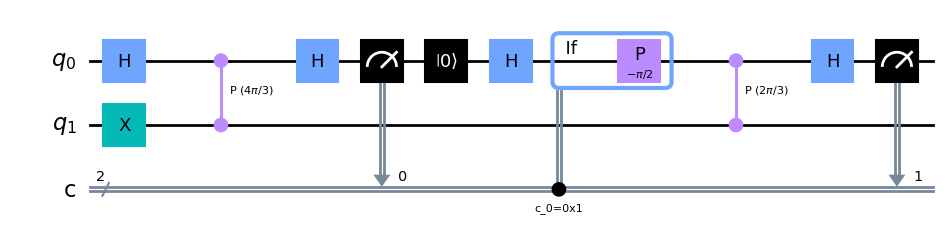

In [9]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qrは2量子ビットレジスタ
    # crは2古典ビットレジスタ

    qc = QuantumCircuit(qr, cr)

    # 初期化する
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # 最下位の位相ビットを取得するために必要なだけ制御ユニタリ演算子を適用する
    u_angle = 2 * np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # X基底で補助量子ビットを測定する
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # 補助量子ビットをリセットし、アダマールゲートで再初期化する
    qc.reset(q0)
    qc.h(q0)

    # 最初の古典ビットを条件として位相補正を適用する
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # 次の位相ビットを取得するために必要なだけ制御ユニタリ演算子を適用する
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # X基底で補助量子ビットを測定し、2番目の古典ビットに格納する
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [10]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'01': 714, '00': 54, '11': 53, '10': 179}
Success probability: 0.714


ご覧のように、今回は期待通りの結果を得ることが保証されているわけではありません。自然な疑問ですが、どうすれば成功確率を上げられるでしょうか？

アルゴリズムが失敗する方法の1つは、最初に測定したビットが正しくないことです。この場合、2番目のビットを測定する前に適用される位相補正も不正確であるため、残りのビットも不正確である可能性が高くなります。この問題を軽減する簡単な方法は、最初の数ビットの測定を何度か繰り返し、多数決でビットを正しく測定する可能性を高めることです。この手順を1つの回路内に実装するには、測定した結果に対して演算を行う必要があります。Qiskitの一時的な制限により、現在、測定したビットに対して演算を行い、その結果に基づいて将来の回路動作を条件付けることはできません。そこで、ここでは各ビットを別々の回路で測定することにします。

以下のコードセルで、位相の1ビット目だけを測定するためのIPE回路を構成し、シミュレーションを行います。


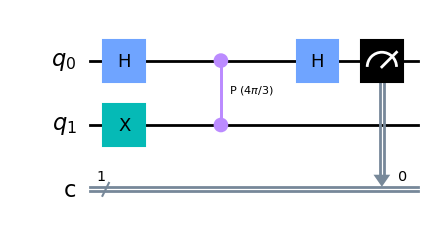

In [11]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qrは2量子ビットレジスタ
    # crは1古典ビットレジスタ

    qc = QuantumCircuit(qr, cr)

    # 初期化する
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # 最下位の位相ビットを取得するために必要なだけ制御ユニタリ演算子を適用する
    u_angle = 2 * np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # X基底で補助量子ビットを測定する
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [12]:
job = sim.run(qc, shots=15)
result = job.result()
counts = result.get_counts()
print(counts)

{'0': 3, '1': 12}


正しいビットが測定されることが多くなってくれたことを期待します。

## Exercise 4 問題

````{admonition} 最下位ビットの値の決定
最後のコードセルの出力の counts ディクショナリーを調べます。最初のビットの正しい値は何ですか？測定される頻度は高くなりましたか？もしそうでないなら、そうなるまで最後のコードセルを再実行してください。

そして、以下のコードセルに、変数 `step1_bit` を、最も多く測定されたビットの値に等しくするコードを書いてください。

```python
step1_bit: int

####### your code goes here #######

print(step1_bit)
```
````

## Exercise 4 解答例

In [13]:
step1_bit: int

step1_bit = 1 if counts["1"] > counts["0"] else 0

print(step1_bit)

1


## Exercise 5 問題

````{admonition} 2ビット目の位相測定回路の実装
次に、位相の2ビット目を測定するための回路を構築してください。この回路の最初のステージを、補助ビットを上記で測定した値に設定するだけのものに置き換えることで、位相の最初のビットについて常に正しい値を測定するようにします。

```python
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")
```
````

## Exercise 5 解答例

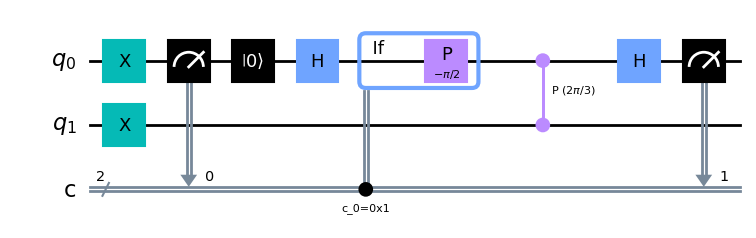

In [15]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qrは2量子ビットレジスタ
    # crは2古典ビットレジスタ

    qc = QuantumCircuit(qr, cr)

    # 初期化
    q0, q1 = qr
    if step1_bit:
        qc.x(q0)
    qc.x(q1)

    # 補助量子ビットを測定する
    c0, c1 = cr
    qc.measure(q0, c0)

    # 補助量子ビットをリセットし、アダマールゲートで再初期化する
    qc.reset(q0)
    qc.h(q0)

    # 最初の古典ビットを条件として位相補正を適用する
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # 次の位相ビットを取得するために必要なだけ制御ユニタリ演算子を適用する
    u_angle = 2 * np.pi / 3
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # X基底で補助量子ビットを測定し、2番目の古典ビットに格納する
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [17]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'11': 67, '01': 933}
Success probability: 0.933


今度は、成功確率が以前よりずっと高くなりました!

## ハードウェアでの実行

最後に、実際のハードウェアでいくつかの回路を実行します！以下のコードセルは、Lab2で作成した $S$ ゲートの位相を測定する回路を初期化して実行します。現在の量子ハードウェアはノイズがあるため、シミュレーターで得られた結果ほど良いものではありません。このLabで作成したその他の回路も自由に実行してみてください。ただし、 $T$ ゲートの位相を測定する Exercise 3 のような大規模な回路では、さらに多くのノイズが発生することに注意してください

なお、以下のコードの実行にはIBM QuantumのAPIトークンが必要です。
コメントアウトを解除し、`token`に用意したAPIトークンを格納してください。

In [18]:
# from qiskit_ibm_provider import IBMProvider

# token = "PASTE_YOUR_TOKEN_HERE" # ここにAPIトークンをペーストする
# IBMProvider.save_account(token=token, overwrite=True)

# provider = IBMProvider()

In [19]:
# hub = "YOUR_HUB"
# group = "YOUR_GROUP"
# project = "YOUR_PROJECT"

# backend_name = "ibm_peekskill"
# backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

In [20]:
# from qiskit import transpile

# qr = QuantumRegister(2, "q")
# cr = ClassicalRegister(2, "c")
# qc = QuantumCircuit(qr, cr)
# qc = step_2_circuit(qr, cr)
# qc_transpiled = transpile(qc, backend)

In [21]:
# job = backend.run(qc_transpiled, shots=1000, dynamic=True)
# job_id = job.job_id()
# print(job_id)

In [22]:
# retrieve_job = provider.retrieve_job(job_id)
# retrieve_job.status()

In [23]:
# from qiskit.tools.visualization import plot_histogram

# counts = retrieve_job.result().get_counts()
# plot_histogram(counts)

このLabは、反復的位相推定に関する[QiskitテキストブックのLab](https://learn.qiskit.org/course/ch-labs/lab-6-iterative-phase-estimation-algorithm) と、[Dynamic circuit ドキュメント](https://quantum-computing.ibm.com/services/resources/docs/resources/manage/systems/dynamic-circuits/Getting-started-with-Dynamic-Circuits)の資料を参考にしました。